In [1]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.dirname(os.path.abspath(current_dir)))
from Grover.grover_num_list_cirq import find_num, find_num_list
from Backend.fake_backend import FakeBackend
from Backend.backend import Backend
from Backend.ibm_backend import IBM_backend

from Result.result import ResultData

from qiskit.visualization import plot_histogram, plot_coupling_map
from backend_operation import run_simulator, get_transpiled_circuits_of_circuit, get_fake_backend_list,get_unitary, get_fake_backend, get_fake_backend_list
from qiskit import transpile
import qiskit.providers.fake_provider
from qiskit_ibm_provider import IBMProvider
from qiskit.transpiler.passes import RemoveBarriers
from qiskit_aer import AerSimulator, Aer

from itertools import permutations

Number of Grover circuits : 1


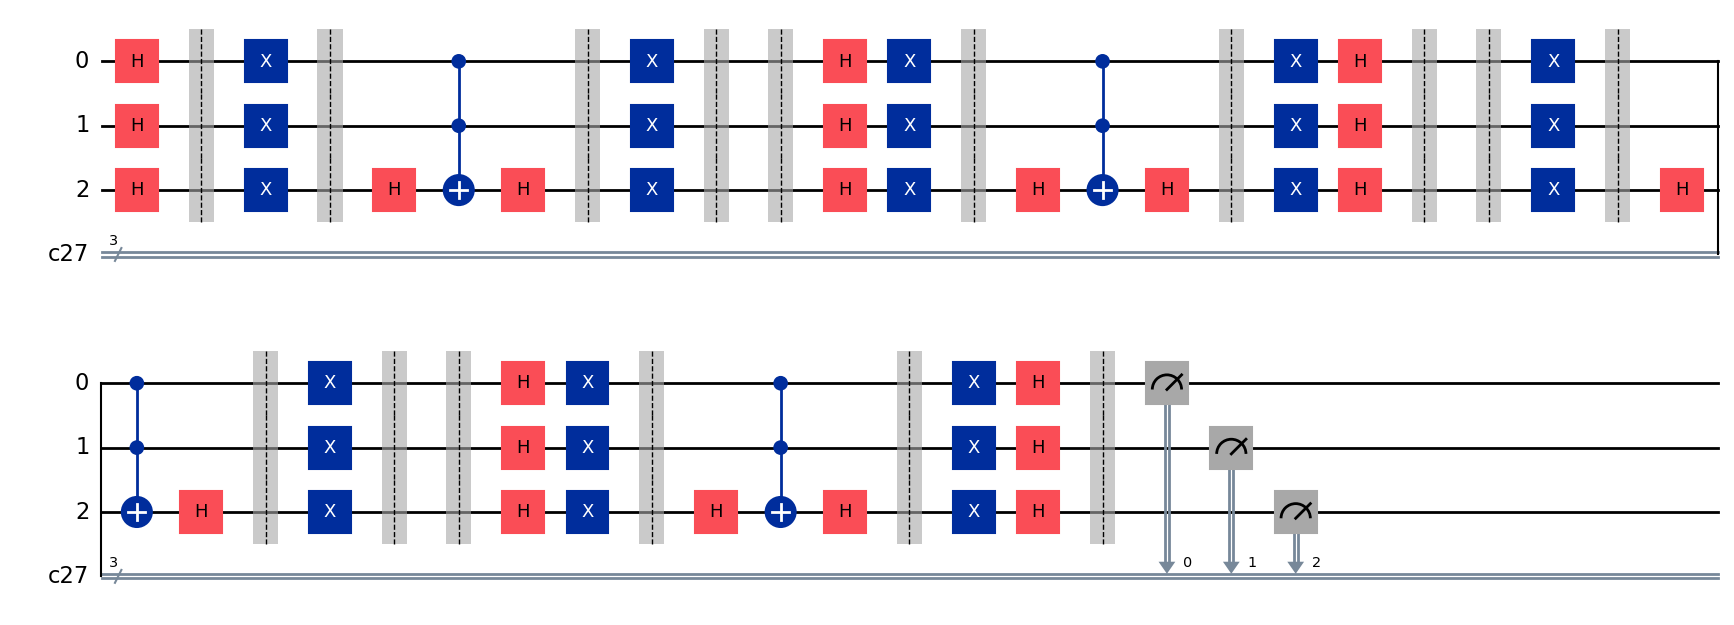

In [75]:
# Sample of Find Number Grover Circuit
find_num_in_world_obj =  find_num()
find_num_in_world_obj.build_iteration(winner_num_list=[0], circuit_nqubits=3, block_diagram=False)
find_num_in_world_obj.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
cur_experiments = find_num_in_world_obj.measure_qc
print(f"Number of Grover circuits : {len(cur_experiments)}")
cur_experiments[0].draw('mpl')

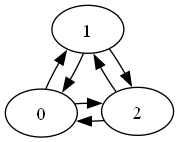

In [76]:
backend = qiskit.providers.fake_provider.GenericBackendV2(num_qubits=3)
backend.coupling_map.draw()

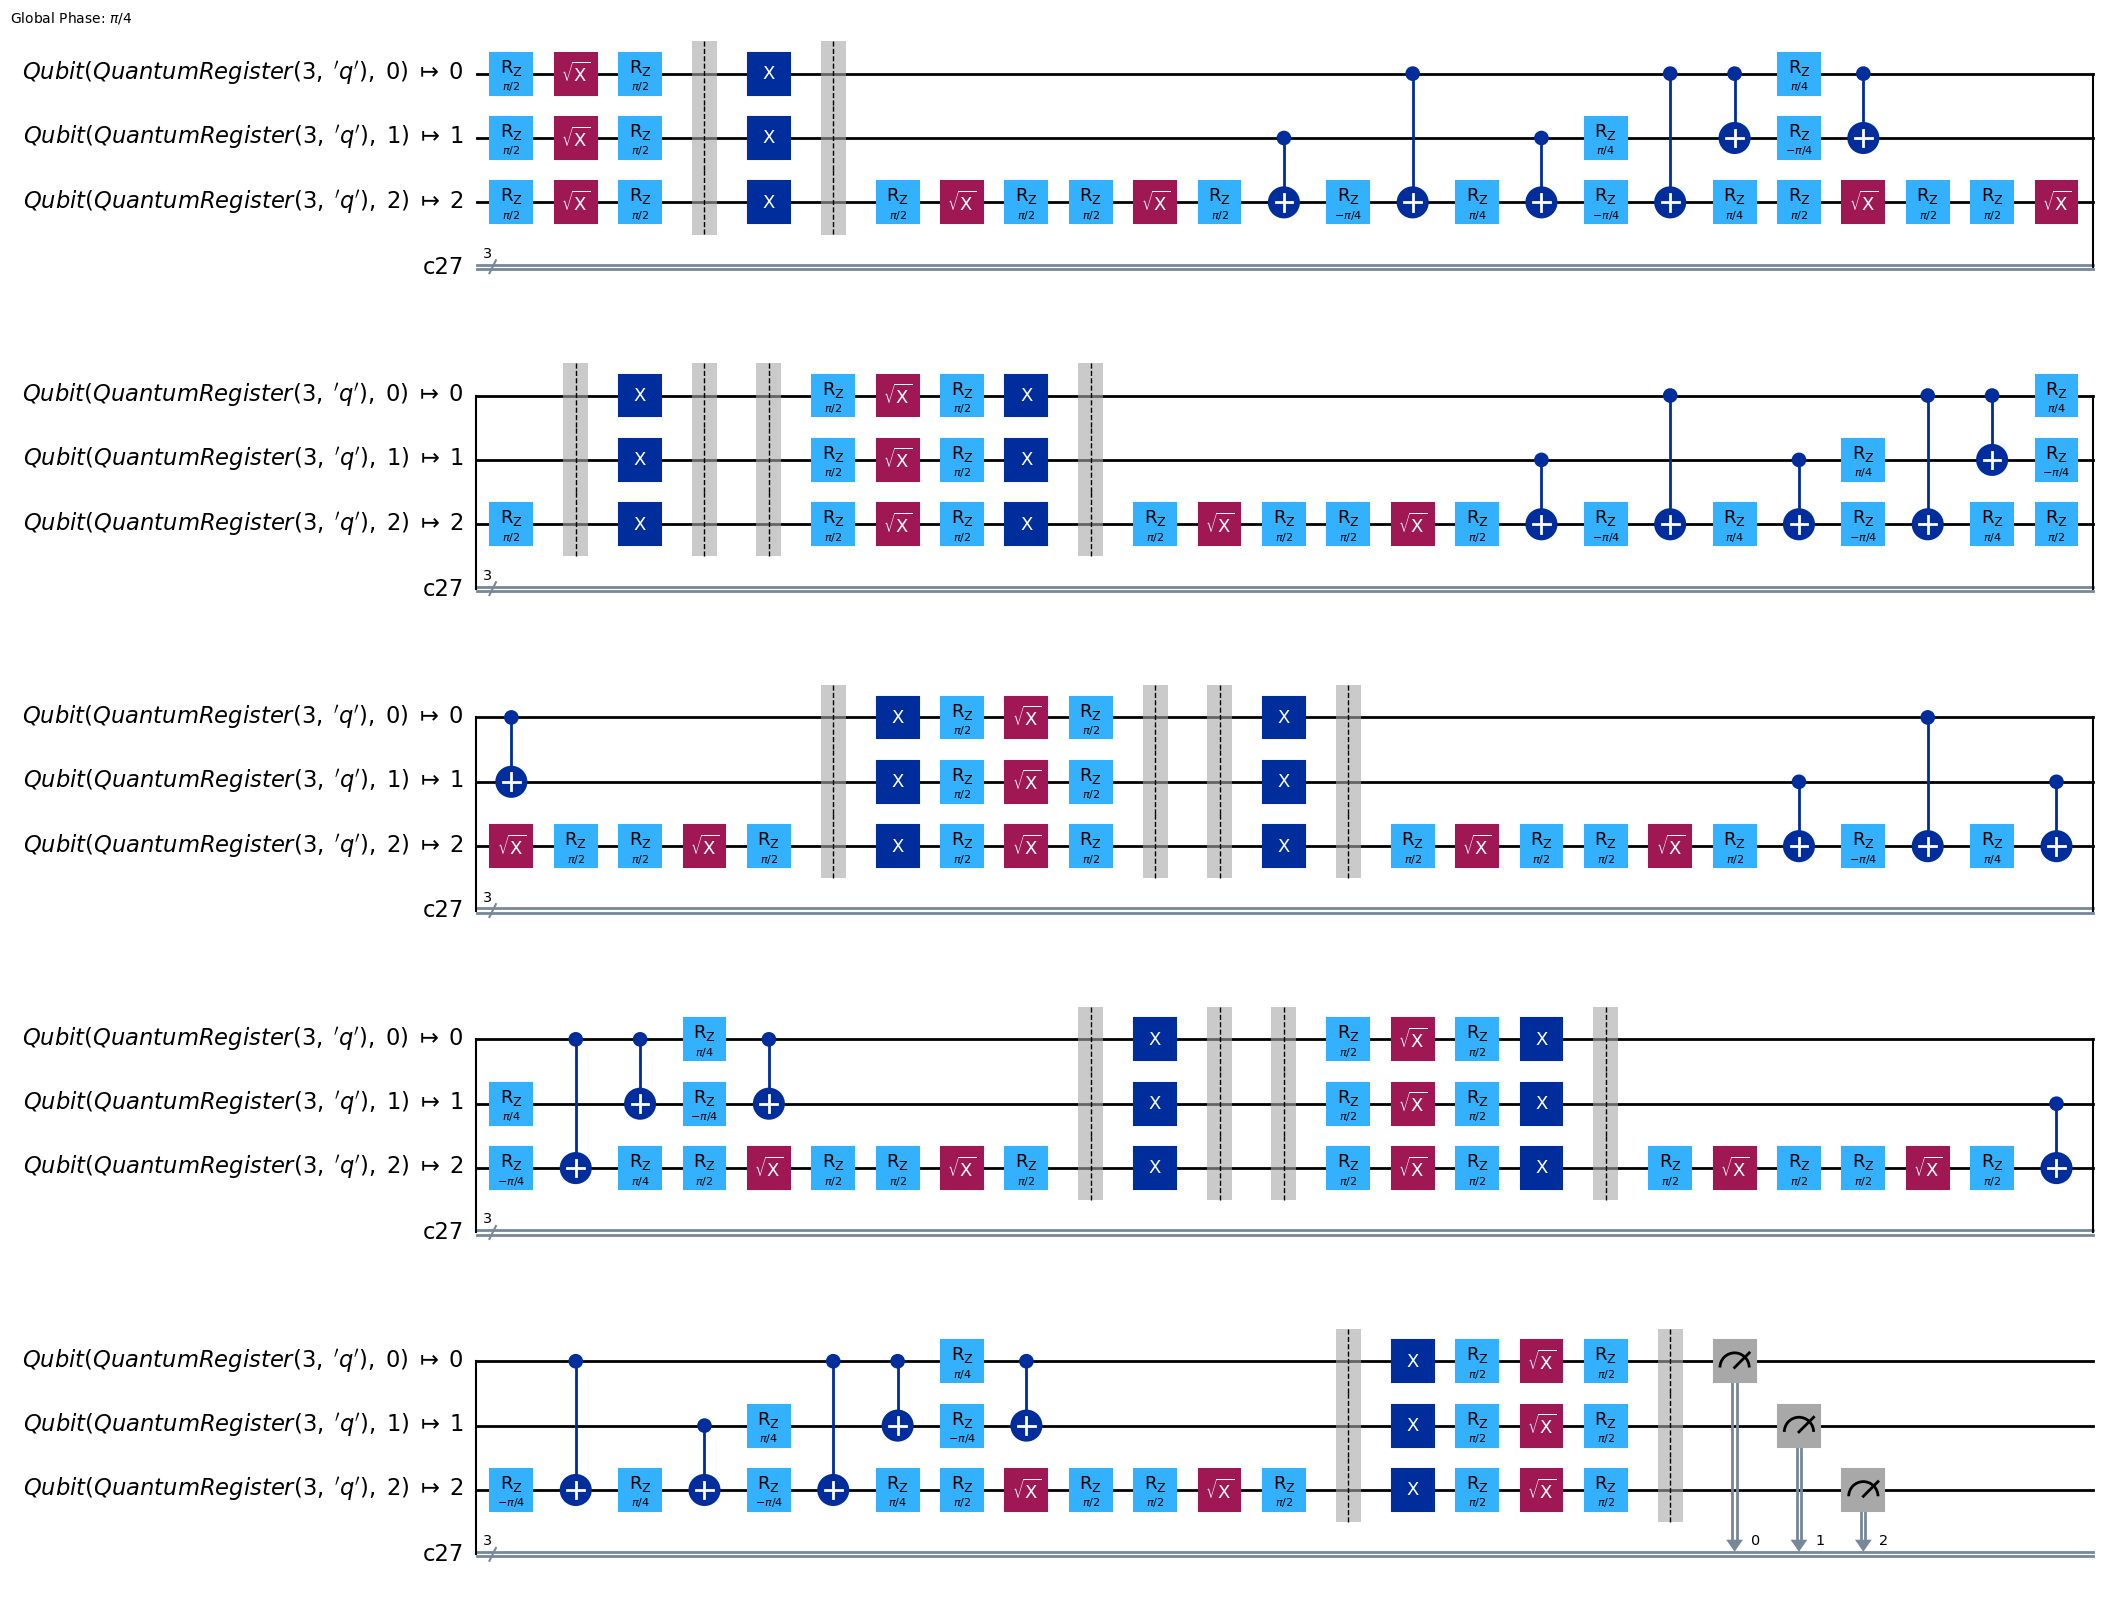

In [77]:
# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuit = transpile(cur_experiments[0], backend, optimization_level=0)
transpiled_circuit.draw('mpl')


In [ ]:
transpiled_circuit = transpile(cur_experiments[0], backend, optimization_level=3)
transpiled_circuit.draw('mpl')

In [2]:
find_num_obj = find_num()
num_qubits = 3
qc_find_num_list = []

for value in range(2**num_qubits):
    find_num_obj.build_iteration(winner_num_list=[value], circuit_nqubits=num_qubits, block_diagram=False)
    find_num_obj.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
    qc_find_num_list.append(find_num_obj.measure_qc[0])

In [3]:
generic_backend = Backend(num_qubits)
backend_names = FakeBackend.get_ibm_fake_backend_names_with_limit(num_qubits)
fake_auckland_backend = FakeBackend.get_ibm_fake_backend('fake_auckland')
print(f"Fake Auckland number of qubits = {fake_auckland_backend.num_qubits}")

Fake Auckland number of qubits = 27


In [4]:
fake_backend_name = 'fake_auckland'
fake_backend = FakeBackend(fake_backend_name)

In [5]:
position_layout = permutations(range(fake_backend.get_backend_qubits()), num_qubits)

In [6]:
position_layout = permutations(range(num_qubits), num_qubits)

In [7]:
qc_find_num_list_without_barriar = [RemoveBarriers()(qc) for qc in qc_find_num_list]

In [8]:
# Add the Generic Aer Full Connectivity
qc_transpiled_list = [
    generic_backend.transpile_save_param(qc=qc, optimization_level=0, initial_layout=None, seed_transpiler=None, input_search = index)
    for index, qc in enumerate(qc_find_num_list_without_barriar)
]
qc_transpiled_list = qc_transpiled_list + [
    generic_backend.transpile_save_param(qc=qc, optimization_level=3, initial_layout=None, seed_transpiler=None, input_search = index)
    for index, qc in enumerate(qc_find_num_list_without_barriar)
]
position_layout = list(position_layout)
# Add the fake backend
for layout in [None] + position_layout:
    qc_transpiled_list = qc_transpiled_list + [
        fake_backend.transpile_save_param(qc=qc, optimization_level=0, initial_layout=layout, seed_transpiler=None, input_search = index)
        for index, qc in enumerate(qc_find_num_list_without_barriar)
    ]
    qc_transpiled_list = qc_transpiled_list + [
        fake_backend.transpile_save_param(qc=qc, optimization_level=3, initial_layout=layout, seed_transpiler=None, input_search = index)
        for index, qc in enumerate(qc_find_num_list_without_barriar)
    ]

In [13]:
# Sample that we entered an input value to the result parameters to save
qc_transpiled_list[60].input_search

4

In [14]:
qc_res  = [
    qc_param.backend.execute(qc_param.transpiled_qc,shots=1024)
    for qc_param in qc_transpiled_list
]

In [15]:
len(qc_res)

128

In [17]:
result = ResultData(qc_res[60])

In [18]:
result.job

In [19]:
result.to_dict()

{'backend_name': 'aer_simulator',
 'backend_version': '0.14.2',
 'date': '2024-07-16T18:05:42.671261',
 'header': None,
 'qobj_id': '',
 'job_id': 'e0d21140-a98c-4eaf-b0d4-ef96dd23a919',
 'status': 'COMPLETED',
 'success': True,
 'results': [{'shots': 1024,
   'success': True,
   'data': {'counts': {'0x1': 49,
     '0x6': 69,
     '0x4': 649,
     '0x0': 58,
     '0x3': 44,
     '0x7': 44,
     '0x5': 50,
     '0x2': 61}},
   'meas_level': <MeasLevel.CLASSIFIED: 2>,
   'header': {'creg_sizes': [],
    'global_phase': 4.440892098500626e-16,
    'memory_slots': 3,
    'n_qubits': 27,
    'name': 'circuit-258',
    'qreg_sizes': [],
    'metadata': {}},
   'status': 'DONE',
   'seed_simulator': 3299590763,
   'metadata': {'batched_shots_optimization': False,
    'required_memory_mb': 1,
    'method': 'density_matrix',
    'active_input_qubits': [0, 1, 2],
    'device': 'CPU',
    'remapped_qubits': False,
    'num_qubits': 3,
    'num_clbits': 3,
    'time_taken': 0.0164659,
    'sample_m

In [20]:
len(qc_transpiled_list)

128

In [27]:
result.get_counts()

{'001': 49,
 '110': 69,
 '100': 649,
 '000': 58,
 '011': 44,
 '111': 44,
 '101': 50,
 '010': 61}

In [28]:
result.get_data()

{'counts': {'0x1': 49,
  '0x6': 69,
  '0x4': 649,
  '0x0': 58,
  '0x3': 44,
  '0x7': 44,
  '0x5': 50,
  '0x2': 61}}

In [21]:
result.to_dict().keys()

dict_keys(['backend_name', 'backend_version', 'date', 'header', 'qobj_id', 'job_id', 'status', 'success', 'results', 'metadata', 'time_taken'])

In [22]:
result.to_dict()['results'][0].keys()

dict_keys(['shots', 'success', 'data', 'meas_level', 'header', 'status', 'seed_simulator', 'metadata', 'time_taken'])

In [23]:
result.to_dict()['results'][0]['time_taken']

0.0164659

In [24]:
result.to_dict()['results'][0]['header']

{'creg_sizes': [],
 'global_phase': 4.440892098500626e-16,
 'memory_slots': 3,
 'n_qubits': 27,
 'name': 'circuit-258',
 'qreg_sizes': [],
 'metadata': {}}

In [25]:
result.to_dict()['results'][0]['data']

{'counts': {'0x1': 49,
  '0x6': 69,
  '0x4': 649,
  '0x0': 58,
  '0x3': 44,
  '0x7': 44,
  '0x5': 50,
  '0x2': 61}}

In [26]:
result.to_dict()['results'][0]['metadata']

{'batched_shots_optimization': False,
 'required_memory_mb': 1,
 'method': 'density_matrix',
 'active_input_qubits': [0, 1, 2],
 'device': 'CPU',
 'remapped_qubits': False,
 'num_qubits': 3,
 'num_clbits': 3,
 'time_taken': 0.0164659,
 'sample_measure_time': 0.0005277,
 'input_qubit_map': [[0, 0], [1, 1], [2, 2]],
 'max_memory_mb': 16282,
 'measure_sampling': True,
 'noise': 'superop',
 'parallel_shots': 1,
 'parallel_state_update': 8,
 'runtime_parameter_bind': False,
 'num_bind_params': 1,
 'fusion': {'enabled': True,
  'threshold': 7,
  'max_fused_qubits': 2,
  'applied': False}}